In [3]:
from __future__ import annotations

from dataclasses import dataclass, replace
from typing import Sequence, Tuple, Optional, List

from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
import graphviz
import numpy as np
from pprint import pprint
from typing import (Callable, Dict, Iterable, Generic, Sequence, Tuple,
                    Mapping, TypeVar, Set)
import random
from rl.distribution import (Categorical, Distribution, FiniteDistribution,
                             SampledDistribution)

S = TypeVar('S')
X = TypeVar('X')


class State(ABC, Generic[S]):
    state: S

    def on_non_terminal(
        self,
        f: Callable[[NonTerminal[S]], X],
        default: X
    ) -> X:
        if isinstance(self, NonTerminal):
            return f(self)
        else:
            return default


@dataclass(frozen=True)
class Terminal(State[S]):
    state: S


@dataclass(frozen=True)
class NonTerminal(State[S]):
    state: S


class MarkovProcess(ABC, Generic[S]):
    '''A Markov process with states of type S.
    '''
    @abstractmethod
    def transition(self, state: NonTerminal[S]) -> Distribution[State[S]]:
        '''Given a state of the process, returns a distribution of
        the next states.  Returning None means we are in a terminal state.
        '''

    def simulate(
        self,
        start_state_distribution: Distribution[NonTerminal[S]]
    ) -> Iterable[State[S]]:
        '''Run a simulation trace of this Markov process, generating the
        states visited during the trace.

        This yields the start state first, then continues yielding
        subsequent states forever or until we hit a terminal state.
        '''

        state: State[S] = start_state_distribution.sample()
        yield state

        while isinstance(state, NonTerminal):
            state = self.transition(state).sample()
            yield state

    def traces(
            self,
            start_state_distribution: Distribution[NonTerminal[S]]
    ) -> Iterable[Iterable[State[S]]]:
        '''Yield simulation traces (the output of `simulate'), sampling a
        start state from the given distribution each time.

        '''
        while True:
            yield self.simulate(start_state_distribution)

@dataclass(frozen=True)
class DollarsAndShares:

    dollars: float
    shares: int


PriceSizePairs = Sequence[DollarsAndShares]
PriceSizePairs = Tuple[DollarsAndShares]

@dataclass(frozen=True)
class OrderBook:

    descending_bids: tuple(PriceSizePairs)
    ascending_asks: Tuple(PriceSizePairs)


    def bid_price(self) -> float:
        return self.descending_bids[0].dollars

    def ask_price(self) -> float:
        return self.ascending_asks[0].dollars

    def mid_price(self) -> float:
        return (self.bid_price() + self.ask_price()) / 2

    def bid_ask_spread(self) -> float:
        return self.ask_price() - self.bid_price()

    def market_depth(self) -> float:
        return self.ascending_asks[-1].dollars - \
            self.descending_bids[-1].dollars

    @staticmethod
    def eat_book(
        ps_pairs: PriceSizePairs,
        shares: int
    ) -> Tuple[DollarsAndShares, PriceSizePairs]:
        '''
        Returned DollarsAndShares represents the pair of
        dollars transacted and the number of shares transacted
        on ps_pairs (with number of shares transacted being less
        than or equal to the input shares).
        Returned PriceSizePairs represents the remainder of the
        ps_pairs after the transacted number of shares have eaten into
        the input ps_pairs.
        '''
        rem_shares: int = shares
        dollars: float = 0.
        for i, d_s in enumerate(ps_pairs):
            this_price: float = d_s.dollars
            this_shares: int = d_s.shares
            dollars += this_price * min(rem_shares, this_shares)
            if rem_shares < this_shares:
                return (
                    DollarsAndShares(dollars=dollars, shares=shares),
                    [DollarsAndShares(
                        dollars=this_price,
                        shares=this_shares - rem_shares
                    )] + list(ps_pairs[i+1:])
                )
            else:
                rem_shares -= this_shares

        return (
            DollarsAndShares(dollars=dollars, shares=shares - rem_shares),
            []
        )

    def sell_limit_order(self, price: float, shares: int) -> \
            Tuple[DollarsAndShares, OrderBook]:
        index: Optional[int] = next((i for i, d_s
                                     in enumerate(self.descending_bids)
                                     if d_s.dollars < price), None)
        eligible_bids: PriceSizePairs = self.descending_bids \
            if index is None else self.descending_bids[:index]
        ineligible_bids: PriceSizePairs = [] if index is None else \
            self.descending_bids[index:]

        d_s, rem_bids = OrderBook.eat_book(eligible_bids, shares)
        new_bids: PriceSizePairs = list(rem_bids) + list(ineligible_bids)
        rem_shares: int = shares - d_s.shares

        if rem_shares > 0:
            new_asks: List[DollarsAndShares] = list(self.ascending_asks)
            index1: Optional[int] = next((i for i, d_s
                                          in enumerate(new_asks)
                                          if d_s.dollars >= price), None)
            if index1 is None:
                new_asks.append(DollarsAndShares(
                    dollars=price,
                    shares=rem_shares
                ))
            elif new_asks[index1].dollars != price:
                new_asks.insert(index1, DollarsAndShares(
                    dollars=price,
                    shares=rem_shares
                ))
            else:
                new_asks[index1] = DollarsAndShares(
                    dollars=price,
                    shares=new_asks[index1].shares + rem_shares
                )
            return d_s, OrderBook(
                ascending_asks=new_asks,
                descending_bids=new_bids
            )
        else:
            return d_s, replace(
                self,
                descending_bids=new_bids
            )

    def sell_market_order(
        self,
        shares: int
    ) -> Tuple[DollarsAndShares, OrderBook]:
        d_s, rem_bids = OrderBook.eat_book(
            self.descending_bids,
            shares
        )
        return (d_s, replace(self, descending_bids=rem_bids))

    def buy_limit_order(self, price: float, shares: int) -> \
            Tuple[DollarsAndShares, OrderBook]:
        index: Optional[int] = next((i for i, d_s
                                     in enumerate(self.ascending_asks)
                                     if d_s.dollars > price), None)
        eligible_asks: PriceSizePairs = self.ascending_asks \
            if index is None else self.ascending_asks[:index]
        ineligible_asks: PriceSizePairs = [] if index is None else \
            self.ascending_asks[index:]

        d_s, rem_asks = OrderBook.eat_book(eligible_asks, shares)
        new_asks: PriceSizePairs = list(rem_asks) + list(ineligible_asks)
        rem_shares: int = shares - d_s.shares

        if rem_shares > 0:
            new_bids: List[DollarsAndShares] = list(self.descending_bids)
            index1: Optional[int] = next((i for i, d_s
                                          in enumerate(new_bids)
                                          if d_s.dollars <= price), None)
            if index1 is None:
                new_bids.append(DollarsAndShares(
                    dollars=price,
                    shares=rem_shares
                ))
            elif new_bids[index1].dollars != price:
                new_bids.insert(index1, DollarsAndShares(
                    dollars=price,
                    shares=rem_shares
                ))
            else:
                new_bids[index1] = DollarsAndShares(
                    dollars=price,
                    shares=new_bids[index1].shares + rem_shares
                )
            return d_s, replace(
                self,
                ascending_asks=new_asks,
                descending_bids=new_bids
            )
        else:
            return d_s, replace(
                self,
                ascending_asks=new_asks
            )

    def buy_market_order(
        self,
        shares: int
    ) -> Tuple[DollarsAndShares, OrderBook]:
        d_s, rem_asks = OrderBook.eat_book(
            self.ascending_asks,
            shares
        )
        return (d_s, replace(self, ascending_asks=rem_asks))

    def pretty_print_order_book(self) -> None:
        from pprint import pprint
        print()
        print("Bids")
        pprint(self.descending_bids)
        print()
        print("Asks")
        print()
        pprint(self.ascending_asks)
        print()

    def display_order_book(self) -> None:
        import matplotlib.pyplot as plt

        bid_prices = [d_s.dollars for d_s in self.descending_bids]
        bid_shares = [d_s.shares for d_s in self.descending_bids]
        if self.descending_bids:
            plt.bar(bid_prices, bid_shares, color='blue')

        ask_prices = [d_s.dollars for d_s in self.ascending_asks]
        ask_shares = [d_s.shares for d_s in self.ascending_asks]
        if self.ascending_asks:
            plt.bar(ask_prices, ask_shares, color='red')

        all_prices = sorted(bid_prices + ask_prices)
        all_ticks = ["%d" % x for x in all_prices]
        plt.xticks(all_prices, all_ticks)
        plt.grid(axis='y')
        plt.xlabel("Prices")
        plt.ylabel("Number of Shares")
        plt.title("Order Book")
        # plt.xticks(x_pos, x)
        plt.show()


if __name__ == '__main__':

    from numpy.random import poisson

    bids: PriceSizePairs = [DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (100 - x) * 10)
    ) for x in range(100, 90, -1)]
    asks: PriceSizePairs = [DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (x - 105) * 10)
    ) for x in range(105, 115, 1)]

    ob0: OrderBook = OrderBook(descending_bids=bids, ascending_asks=asks)
    ob0.pretty_print_order_book()
    ob0.display_order_book()

    print("Sell Limit Order of (107, 40)")
    print()
    d_s1, ob1 = ob0.sell_limit_order(107, 40)
    proceeds1: float = d_s1.dollars
    shares_sold1: int = d_s1.shares
    print(f"Sales Proceeds = {proceeds1:.2f}, Shares Sold = {shares_sold1:d}")
    ob1.pretty_print_order_book()
    ob1.display_order_book()
    ob0.pretty_print_order_book()
    ob0.display_order_book()
    print("Sell Market Order of 120")
    print()
    d_s2, ob2 = ob1.sell_market_order(120)
    proceeds2: float = d_s2.dollars
    shares_sold2: int = d_s2.shares
    print(f"Sales Proceeds = {proceeds2:.2f}, Shares Sold = {shares_sold2:d}")
    ob2.pretty_print_order_book()
    ob2.display_order_book()

    print("Buy Limit Order of (100, 80)")
    print()
    d_s3, ob3 = ob2.buy_limit_order(100, 80)
    bill3: float = d_s3.dollars
    shares_bought3: int = d_s3.shares
    print(f"Purchase Bill = {bill3:.2f}, Shares Bought = {shares_bought3:d}")
    ob3.pretty_print_order_book()
    ob3.display_order_book()

    print("Sell Limit Order of (104, 60)")
    print()
    d_s4, ob4 = ob3.sell_limit_order(104, 60)
    proceeds4: float = d_s4.dollars
    shares_sold4: int = d_s4.shares
    print(f"Sales Proceeds = {proceeds4:.2f}, Shares Sold = {shares_sold4:d}")
    ob4.pretty_print_order_book()
    ob4.display_order_book()

    print("Buy Market Order of 150")
    print()
    d_s5, ob5 = ob4.buy_market_order(150)
    bill5: float = d_s5.dollars
    shares_bought5: int = d_s5.shares
    print(f"Purchase Bill = {bill5:.2f}, Shares Bought = {shares_bought5:d}")
    ob5.pretty_print_order_book()
    ob5.display_order_book()



Bids
[DollarsAndShares(dollars=100, shares=96),
 DollarsAndShares(dollars=99, shares=99),
 DollarsAndShares(dollars=98, shares=91),
 DollarsAndShares(dollars=97, shares=73),
 DollarsAndShares(dollars=96, shares=53),
 DollarsAndShares(dollars=95, shares=48),
 DollarsAndShares(dollars=94, shares=61),
 DollarsAndShares(dollars=93, shares=25),
 DollarsAndShares(dollars=92, shares=26),
 DollarsAndShares(dollars=91, shares=9)]

Asks

[DollarsAndShares(dollars=105, shares=118),
 DollarsAndShares(dollars=106, shares=81),
 DollarsAndShares(dollars=107, shares=71),
 DollarsAndShares(dollars=108, shares=79),
 DollarsAndShares(dollars=109, shares=70),
 DollarsAndShares(dollars=110, shares=70),
 DollarsAndShares(dollars=111, shares=37),
 DollarsAndShares(dollars=112, shares=42),
 DollarsAndShares(dollars=113, shares=18),
 DollarsAndShares(dollars=114, shares=20)]



<Figure size 640x480 with 1 Axes>

Sell Limit Order of (107, 40)

Sales Proceeds = 0.00, Shares Sold = 0

Bids
[DollarsAndShares(dollars=100, shares=96),
 DollarsAndShares(dollars=99, shares=99),
 DollarsAndShares(dollars=98, shares=91),
 DollarsAndShares(dollars=97, shares=73),
 DollarsAndShares(dollars=96, shares=53),
 DollarsAndShares(dollars=95, shares=48),
 DollarsAndShares(dollars=94, shares=61),
 DollarsAndShares(dollars=93, shares=25),
 DollarsAndShares(dollars=92, shares=26),
 DollarsAndShares(dollars=91, shares=9)]

Asks

[DollarsAndShares(dollars=105, shares=118),
 DollarsAndShares(dollars=106, shares=81),
 DollarsAndShares(dollars=107, shares=111),
 DollarsAndShares(dollars=108, shares=79),
 DollarsAndShares(dollars=109, shares=70),
 DollarsAndShares(dollars=110, shares=70),
 DollarsAndShares(dollars=111, shares=37),
 DollarsAndShares(dollars=112, shares=42),
 DollarsAndShares(dollars=113, shares=18),
 DollarsAndShares(dollars=114, shares=20)]



<Figure size 640x480 with 1 Axes>


Bids
[DollarsAndShares(dollars=100, shares=96),
 DollarsAndShares(dollars=99, shares=99),
 DollarsAndShares(dollars=98, shares=91),
 DollarsAndShares(dollars=97, shares=73),
 DollarsAndShares(dollars=96, shares=53),
 DollarsAndShares(dollars=95, shares=48),
 DollarsAndShares(dollars=94, shares=61),
 DollarsAndShares(dollars=93, shares=25),
 DollarsAndShares(dollars=92, shares=26),
 DollarsAndShares(dollars=91, shares=9)]

Asks

[DollarsAndShares(dollars=105, shares=118),
 DollarsAndShares(dollars=106, shares=81),
 DollarsAndShares(dollars=107, shares=71),
 DollarsAndShares(dollars=108, shares=79),
 DollarsAndShares(dollars=109, shares=70),
 DollarsAndShares(dollars=110, shares=70),
 DollarsAndShares(dollars=111, shares=37),
 DollarsAndShares(dollars=112, shares=42),
 DollarsAndShares(dollars=113, shares=18),
 DollarsAndShares(dollars=114, shares=20)]



<Figure size 640x480 with 1 Axes>

Sell Market Order of 120

Sales Proceeds = 11976.00, Shares Sold = 120

Bids
[DollarsAndShares(dollars=99, shares=75),
 DollarsAndShares(dollars=98, shares=91),
 DollarsAndShares(dollars=97, shares=73),
 DollarsAndShares(dollars=96, shares=53),
 DollarsAndShares(dollars=95, shares=48),
 DollarsAndShares(dollars=94, shares=61),
 DollarsAndShares(dollars=93, shares=25),
 DollarsAndShares(dollars=92, shares=26),
 DollarsAndShares(dollars=91, shares=9)]

Asks

[DollarsAndShares(dollars=105, shares=118),
 DollarsAndShares(dollars=106, shares=81),
 DollarsAndShares(dollars=107, shares=111),
 DollarsAndShares(dollars=108, shares=79),
 DollarsAndShares(dollars=109, shares=70),
 DollarsAndShares(dollars=110, shares=70),
 DollarsAndShares(dollars=111, shares=37),
 DollarsAndShares(dollars=112, shares=42),
 DollarsAndShares(dollars=113, shares=18),
 DollarsAndShares(dollars=114, shares=20)]



<Figure size 640x480 with 1 Axes>

Buy Limit Order of (100, 80)

Purchase Bill = 0.00, Shares Bought = 0

Bids
[DollarsAndShares(dollars=100, shares=80),
 DollarsAndShares(dollars=99, shares=75),
 DollarsAndShares(dollars=98, shares=91),
 DollarsAndShares(dollars=97, shares=73),
 DollarsAndShares(dollars=96, shares=53),
 DollarsAndShares(dollars=95, shares=48),
 DollarsAndShares(dollars=94, shares=61),
 DollarsAndShares(dollars=93, shares=25),
 DollarsAndShares(dollars=92, shares=26),
 DollarsAndShares(dollars=91, shares=9)]

Asks

[DollarsAndShares(dollars=105, shares=118),
 DollarsAndShares(dollars=106, shares=81),
 DollarsAndShares(dollars=107, shares=111),
 DollarsAndShares(dollars=108, shares=79),
 DollarsAndShares(dollars=109, shares=70),
 DollarsAndShares(dollars=110, shares=70),
 DollarsAndShares(dollars=111, shares=37),
 DollarsAndShares(dollars=112, shares=42),
 DollarsAndShares(dollars=113, shares=18),
 DollarsAndShares(dollars=114, shares=20)]



<Figure size 640x480 with 1 Axes>

Sell Limit Order of (104, 60)

Sales Proceeds = 0.00, Shares Sold = 0

Bids
[DollarsAndShares(dollars=100, shares=80),
 DollarsAndShares(dollars=99, shares=75),
 DollarsAndShares(dollars=98, shares=91),
 DollarsAndShares(dollars=97, shares=73),
 DollarsAndShares(dollars=96, shares=53),
 DollarsAndShares(dollars=95, shares=48),
 DollarsAndShares(dollars=94, shares=61),
 DollarsAndShares(dollars=93, shares=25),
 DollarsAndShares(dollars=92, shares=26),
 DollarsAndShares(dollars=91, shares=9)]

Asks

[DollarsAndShares(dollars=104, shares=60),
 DollarsAndShares(dollars=105, shares=118),
 DollarsAndShares(dollars=106, shares=81),
 DollarsAndShares(dollars=107, shares=111),
 DollarsAndShares(dollars=108, shares=79),
 DollarsAndShares(dollars=109, shares=70),
 DollarsAndShares(dollars=110, shares=70),
 DollarsAndShares(dollars=111, shares=37),
 DollarsAndShares(dollars=112, shares=42),
 DollarsAndShares(dollars=113, shares=18),
 DollarsAndShares(dollars=114, shares=20)]



<Figure size 640x480 with 1 Axes>

Buy Market Order of 150

Purchase Bill = 15690.00, Shares Bought = 150

Bids
[DollarsAndShares(dollars=100, shares=80),
 DollarsAndShares(dollars=99, shares=75),
 DollarsAndShares(dollars=98, shares=91),
 DollarsAndShares(dollars=97, shares=73),
 DollarsAndShares(dollars=96, shares=53),
 DollarsAndShares(dollars=95, shares=48),
 DollarsAndShares(dollars=94, shares=61),
 DollarsAndShares(dollars=93, shares=25),
 DollarsAndShares(dollars=92, shares=26),
 DollarsAndShares(dollars=91, shares=9)]

Asks

[DollarsAndShares(dollars=105, shares=28),
 DollarsAndShares(dollars=106, shares=81),
 DollarsAndShares(dollars=107, shares=111),
 DollarsAndShares(dollars=108, shares=79),
 DollarsAndShares(dollars=109, shares=70),
 DollarsAndShares(dollars=110, shares=70),
 DollarsAndShares(dollars=111, shares=37),
 DollarsAndShares(dollars=112, shares=42),
 DollarsAndShares(dollars=113, shares=18),
 DollarsAndShares(dollars=114, shares=20)]



<Figure size 640x480 with 1 Axes>

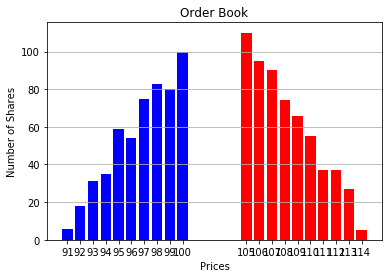

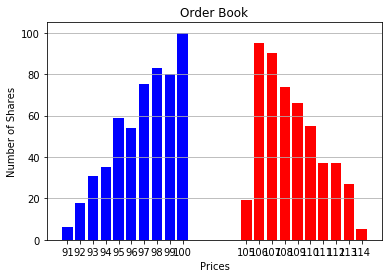

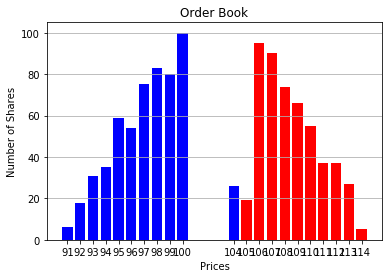

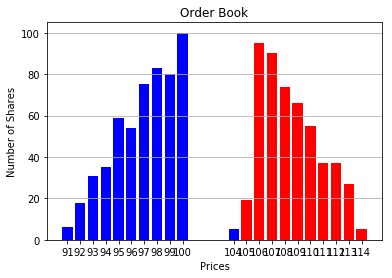

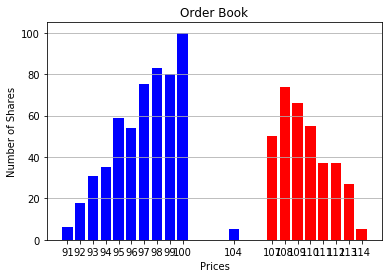

In [4]:
####### MY IMPLEMENTATION HW9 QUESTION-1 #####
bids: PriceSizePairs = [DollarsAndShares(
    dollars=x,
    shares=poisson(100. - (100 - x) * 10)
) for x in range(100, 90, -1)]
asks: PriceSizePairs = [DollarsAndShares(
    dollars=x,
    shares=poisson(100. - (x - 105) * 10)
) for x in range(105, 115, 1)]
ob0: OrderBook = OrderBook(descending_bids=bids, ascending_asks=asks)

current_pos = ob0

nb_trial = 5
for _ in range(nb_trial):
    order_sets = []
    sell_market = []
    buy_market = []
    sell_limit = []
    buy_limit = []
    for i in range(20,200):
        sell_market.append(current_pos.sell_market_order(i)[1])
    for i in range(20,200):
        buy_market.append(current_pos.buy_market_order(i)[1])

    for i in range(20,200):
        for j in range(91,115):
            sell_limit.append(current_pos.sell_limit_order(j,i)[1])
    for i in range(20,200):
        for j in range(91,115):
            buy_limit.append(current_pos.buy_limit_order(j,i)[1])

    order_sets.append(sell_market)
    order_sets.append(buy_market)
    order_sets.append(sell_limit)
    order_sets.append(buy_limit)
    current_pos.display_order_book()
    current_pos = random.choice(random.choice(order_sets))

In [6]:
####### HW9 QUESTION-2

from dataclasses import dataclass
from typing import Callable, Sequence, Tuple, Iterator
from rl.distribution import Distribution, SampledDistribution, Choose
from rl.function_approx import FunctionApprox, LinearFunctionApprox
from rl.markov_decision_process import MarkovDecisionProcess, \
    NonTerminal, State
from rl.policy import DeterministicPolicy
from rl.approximate_dynamic_programming import back_opt_vf_and_policy, \
    ValueFunctionApprox


@dataclass(frozen=True)
class PriceAndShares:
    price: float
    shares: int

MU=0
SIGMA=1

@dataclass(frozen=True)
class OptimalOrderExecution:
    '''
    shares refers to the total number of shares N to be sold over
    T time steps.

    time_steps refers to the number of time steps T.

    avg_exec_price_diff refers to the time-sequenced functions g_t
    that gives the average reduction in the price obtained by the
    Market Order at time t due to eating into the Buy LOs. g_t is
    a function of PriceAndShares that represents the pair of Price P_t
    and MO size N_t. Sales Proceeds = N_t*(P_t - g_t(P_t, N_t)).

    price_dynamics refers to the time-sequenced functions f_t that
    represents the price dynamics: P_{t+1} ~ f_t(P_t, N_t). f_t
    outputs a distribution of prices.

    utility_func refers to the Utility of Sales proceeds function,
    incorporating any risk-aversion.

    discount_factor refers to the discount factor gamma.

    func_approx refers to the FunctionApprox required to approximate
    the Value Function for each time step.

    initial_price_distribution refers to the distribution of prices
    at time 0 (needed to generate the samples of states at each time step,
    needed in the approximate backward induction algorithm).
    '''
    shares: int
    time_steps: int
    avg_exec_price_diff: Sequence[Callable[[PriceAndShares], float]]
    price_dynamics: Sequence[Callable[[PriceAndShares], Distribution[float]]]
    utility_func: Callable[[float], float]
    discount_factor: float
    func_approx: ValueFunctionApprox[PriceAndShares]
    initial_price_distribution: Distribution[float]
    xs:Sequence[float]


    def get_mdp(self, t: int) -> MarkovDecisionProcess[PriceAndShares, int]:
        
        # for tt in range(self.time_steps):
        #     if tt==0:
        #         self.xs[tt] = np.random(self.mu_ro,self.sigma_ro)
        #     else:
        #         self.xs[tt] = self.xs[tt-1] * self.ro + np.random(self.mu_ro,self.sigma_ro)
        
        # for tt in range(self.time_steps):
        #     def f(x):
        #         price = x.price
        #         shares = x.shares
        #         return price*(self.beta*shares + self.theta * self.xs[tt])
        #     self.avg_exec_price_diff[tt] = f


        # for tt in range(self.time_steps):
        #     def f(x):
        #         price = x.price
        #         class Dist(Distribution):
        #             def sample(self):
        #                 a = np.random.normal(loc=MU,scale=SIGMA)
        #                 return price*np.exp(a)
        #             def expectation(self):
        #                 return 
        #         d_ = Dist()
        #         return d_
        #     self.price_dynamics[tt] = f
        



        """
        State is (Price P_t, Remaining Shares R_t)
        Action is shares sold N_t
        """

        utility_f: Callable[[float], float] = self.utility_func
        price_diff: Sequence[Callable[[PriceAndShares], float]] = \
            self.avg_exec_price_diff
        dynamics: Sequence[Callable[[PriceAndShares], Distribution[float]]] = \
            self.price_dynamics
        steps: int = self.time_steps

            


        class OptimalExecutionMDP(MarkovDecisionProcess[PriceAndShares, int]):

            def step(
                self,
                p_r: NonTerminal[PriceAndShares],
                sell: int
            ) -> SampledDistribution[Tuple[State[PriceAndShares],
                                           float]]:

                def sr_sampler_func(
                    p_r=p_r,
                    sell=sell
                ) -> Tuple[State[PriceAndShares], float]:
                    p_s: PriceAndShares = PriceAndShares(
                        price=p_r.state.price,
                        shares=sell
                    )
                    next_price: float = dynamics[t](p_s).sample()
                    next_rem: int = p_r.state.shares - sell
                    next_state: PriceAndShares = PriceAndShares(
                        price=next_price,
                        shares=next_rem
                    )
                    reward: float = utility_f(
                        sell * (p_r.state.price - price_diff[t](p_s))
                    )
                    return (NonTerminal(next_state), reward)

                return SampledDistribution(
                    sampler=sr_sampler_func,
                    expectation_samples=100
                )

            def actions(self, p_s: NonTerminal[PriceAndShares]) -> \
                    Iterator[int]:
                if t == steps - 1:
                    return iter([p_s.state.shares])
                else:
                    return iter(range(p_s.state.shares + 1))

        return OptimalExecutionMDP()

    def get_states_distribution(self, t: int) -> \
            SampledDistribution[NonTerminal[PriceAndShares]]:

        def states_sampler_func() -> NonTerminal[PriceAndShares]:
            price: float = self.initial_price_distribution.sample()
            rem: int = self.shares
            for i in range(t):
                sell: int = Choose(range(rem + 1)).sample()
                # print(self.price_dynamics[i](PriceAndShares(
                #     price=price,
                #     shares=rem
                # )))
                price = self.price_dynamics[i](PriceAndShares(
                    price=price,
                    shares=rem
                )).sample()
                # print(price)
                rem -= sell
            return NonTerminal(PriceAndShares(
                price=price,
                shares=rem
            ))

        return SampledDistribution(states_sampler_func)

    def backward_induction_vf_and_pi(
        self
    ) -> Iterator[Tuple[ValueFunctionApprox[PriceAndShares],
                        DeterministicPolicy[PriceAndShares, int]]]:

        mdp_f0_mu_triples: Sequence[Tuple[
            MarkovDecisionProcess[PriceAndShares, int],
            ValueFunctionApprox[PriceAndShares],
            SampledDistribution[NonTerminal[PriceAndShares]]
        ]] = [(
            self.get_mdp(i),
            self.func_approx,
            self.get_states_distribution(i)
        ) for i in range(self.time_steps)]

        num_state_samples: int = 10000
        error_tolerance: float = 1e-3

        return back_opt_vf_and_policy(
            mdp_f0_mu_triples=mdp_f0_mu_triples,
            γ=self.discount_factor,
            num_state_samples=num_state_samples,
            error_tolerance=error_tolerance
        )


if __name__ == '__main__':

    from rl.distribution import Gaussian

    init_price_mean: float = 100.0
    init_price_stdev: float = 10.0
    num_shares: int = 100
    num_time_steps: int = 5
    alpha: float = 0.03
    beta: float = 0.05
    xs = [0 for _ in range(num_time_steps)]
    mu_zeta, sigma_zeta = 0, 1
    ro = 0.7
    theta: float = 0.03

    mu_z,sigma_z_sqr = 0,1
    ro = 0.3
    mu_ro,sigma_ro = 0,1

    beta=0.2
    theta=0.2

    for tt in range(num_time_steps):
        if tt==0:
            xs[tt] = np.random.normal(mu_zeta,sigma_zeta)
        else:
            xs[tt] = xs[tt-1] * ro + np.random.normal(mu_zeta,sigma_zeta)


    price_diff = [lambda p_s: beta * p_s.shares + theta*xs[_] for _ in range(num_time_steps)]
    dynamics = [lambda p_s: Gaussian(
        μ=p_s.price - alpha * p_s.shares,
        σ=0.
    ) for _ in range(num_time_steps)]


    for tt in range(num_time_steps):
        def f(x):
            price = x.price
            class Dist(Distribution):
                def sample(self):
                    a = np.random.normal(loc=MU,scale=SIGMA/100)
                    return price*np.exp(a)
                def expectation(self):
                    return 
            d_ = Dist()
            return d_
        dynamics[tt] = f


    ffs = [
        lambda p_s: p_s.state.price * p_s.state.shares,
        lambda p_s: float(p_s.state.shares * p_s.state.shares)
    ]
    fa: FunctionApprox = LinearFunctionApprox.create(feature_functions=ffs)
    init_price_distrib: Gaussian = Gaussian(
        μ=init_price_mean,
        σ=init_price_stdev
    )

    ooe: OptimalOrderExecution = OptimalOrderExecution(
        shares=num_shares,
        time_steps=num_time_steps,
        avg_exec_price_diff=price_diff,
        price_dynamics=dynamics,
        utility_func=lambda x: x,
        discount_factor=1,
        func_approx=fa,
        initial_price_distribution=init_price_distrib,
        xs = xs
    )

    avg_exec_price_diff: Sequence[Callable[[PriceAndShares], float]]
    price_dynamics: Sequence[Callable[[PriceAndShares], Distribution[float]]]
    utility_func: Callable[[float], float]
    discount_factor: float
    func_approx: ValueFunctionApprox[PriceAndShares]
    initial_price_distribution: Distribution[float]
    mu_z,sigma_z_sqr = 0,1
    ro = 0.3
    mu_ro,sigma_ro = 0,1
    xs:Sequence[float]
    beta=0.2
    theta=0.2


    it_vf: Iterator[Tuple[ValueFunctionApprox[PriceAndShares],
                          DeterministicPolicy[PriceAndShares, int]]] = \
        ooe.backward_induction_vf_and_pi()

    state: PriceAndShares = PriceAndShares(
        price=init_price_mean,
        shares=num_shares
    )
    print("Backward Induction: VF And Policy")
    print("---------------------------------")
    print()
    for t, (vf, pol) in enumerate(it_vf):
        print(f"Time {t:d}")
        print()
        opt_sale: int = pol.action_for(state)
        val: float = vf(NonTerminal(state))
        print(f"Optimal Sales = {opt_sale:d}, Opt Val = {val:.3f}")
        print()
        print("Optimal Weights below:")
        print(vf.weights.weights)
        print()

    print("Analytical Solution")
    print("-------------------")
    print()

    for t in range(num_time_steps):
        print(f"Time {t:d}")
        print()
        left: int = num_time_steps - t
        opt_sale_anal: float = num_shares / num_time_steps
        wt1: float = 1
        wt2: float = -(2 * beta + alpha * (left - 1)) / (2 * left)
        val_anal: float = wt1 * state.price * state.shares + \
            wt2 * state.shares * state.shares

        print(f"Optimal Sales = {opt_sale_anal:.3f}, Opt Val = {val_anal:.3f}")
        print(f"Weight1 = {wt1:.3f}")
        print(f"Weight2 = {wt2:.3f}")
        print()


KeyboardInterrupt: 

In [1]:

# from dataclasses import dataclass
# from typing import Callable, Sequence, Tuple, Iterator
# from rl.distribution import Distribution, SampledDistribution, Choose
# from rl.function_approx import FunctionApprox, LinearFunctionApprox
# from rl.markov_decision_process import MarkovDecisionProcess, \
#     NonTerminal, State
# from rl.policy import DeterministicPolicy
# from rl.approximate_dynamic_programming import back_opt_vf_and_policy, \
#     ValueFunctionApprox


# @dataclass(frozen=True)
# class PriceAndShares:
#     price: float
#     shares: int


# @dataclass(frozen=True)
# class OptimalOrderExecution:
#     '''
#     shares refers to the total number of shares N to be sold over
#     T time steps.

#     time_steps refers to the number of time steps T.

#     avg_exec_price_diff refers to the time-sequenced functions g_t
#     that gives the average reduction in the price obtained by the
#     Market Order at time t due to eating into the Buy LOs. g_t is
#     a function of PriceAndShares that represents the pair of Price P_t
#     and MO size N_t. Sales Proceeds = N_t*(P_t - g_t(P_t, N_t)).

#     price_dynamics refers to the time-sequenced functions f_t that
#     represents the price dynamics: P_{t+1} ~ f_t(P_t, N_t). f_t
#     outputs a distribution of prices.

#     utility_func refers to the Utility of Sales proceeds function,
#     incorporating any risk-aversion.

#     discount_factor refers to the discount factor gamma.

#     func_approx refers to the FunctionApprox required to approximate
#     the Value Function for each time step.

#     initial_price_distribution refers to the distribution of prices
#     at time 0 (needed to generate the samples of states at each time step,
#     needed in the approximate backward induction algorithm).
#     '''
#     shares: int
#     time_steps: int
#     avg_exec_price_diff: Sequence[Callable[[PriceAndShares], float]]
#     price_dynamics: Sequence[Callable[[PriceAndShares], Distribution[float]]]
#     utility_func: Callable[[float], float]
#     discount_factor: float
#     func_approx: ValueFunctionApprox[PriceAndShares]
#     initial_price_distribution: Distribution[float]

#     def get_mdp(self, t: int) -> MarkovDecisionProcess[PriceAndShares, int]:
#         """
#         State is (Price P_t, Remaining Shares R_t)
#         Action is shares sold N_t
#         """

#         utility_f: Callable[[float], float] = self.utility_func
#         price_diff: Sequence[Callable[[PriceAndShares], float]] = \
#             self.avg_exec_price_diff
#         dynamics: Sequence[Callable[[PriceAndShares], Distribution[float]]] = \
#             self.price_dynamics
#         steps: int = self.time_steps

#         class OptimalExecutionMDP(MarkovDecisionProcess[PriceAndShares, int]):

#             def step(
#                 self,
#                 p_r: NonTerminal[PriceAndShares],
#                 sell: int
#             ) -> SampledDistribution[Tuple[State[PriceAndShares],
#                                            float]]:

#                 def sr_sampler_func(
#                     p_r=p_r,
#                     sell=sell
#                 ) -> Tuple[State[PriceAndShares], float]:
#                     p_s: PriceAndShares = PriceAndShares(
#                         price=p_r.state.price,
#                         shares=sell
#                     )
#                     next_price: float = dynamics[t](p_s).sample()
#                     next_rem: int = p_r.state.shares - sell
#                     next_state: PriceAndShares = PriceAndShares(
#                         price=next_price,
#                         shares=next_rem
#                     )
#                     reward: float = utility_f(
#                         sell * (p_r.state.price - price_diff[t](p_s))
#                     )
#                     return (NonTerminal(next_state), reward)

#                 return SampledDistribution(
#                     sampler=sr_sampler_func,
#                     expectation_samples=100
#                 )

#             def actions(self, p_s: NonTerminal[PriceAndShares]) -> \
#                     Iterator[int]:
#                 if t == steps - 1:
#                     return iter([p_s.state.shares])
#                 else:
#                     return iter(range(p_s.state.shares + 1))

#         return OptimalExecutionMDP()

#     def get_states_distribution(self, t: int) -> \
#             SampledDistribution[NonTerminal[PriceAndShares]]:

#         def states_sampler_func() -> NonTerminal[PriceAndShares]:
#             price: float = self.initial_price_distribution.sample()
#             rem: int = self.shares
#             for i in range(t):
#                 sell: int = Choose(range(rem + 1)).sample()
#                 price = self.price_dynamics[i](PriceAndShares(
#                     price=price,
#                     shares=rem
#                 )).sample()
#                 rem -= sell
#             return NonTerminal(PriceAndShares(
#                 price=price,
#                 shares=rem
#             ))

#         return SampledDistribution(states_sampler_func)

#     def backward_induction_vf_and_pi(
#         self
#     ) -> Iterator[Tuple[ValueFunctionApprox[PriceAndShares],
#                         DeterministicPolicy[PriceAndShares, int]]]:

#         mdp_f0_mu_triples: Sequence[Tuple[
#             MarkovDecisionProcess[PriceAndShares, int],
#             ValueFunctionApprox[PriceAndShares],
#             SampledDistribution[NonTerminal[PriceAndShares]]
#         ]] = [(
#             self.get_mdp(i),
#             self.func_approx,
#             self.get_states_distribution(i)
#         ) for i in range(self.time_steps)]

#         num_state_samples: int = 10000
#         error_tolerance: float = 1e-3

#         return back_opt_vf_and_policy(
#             mdp_f0_mu_triples=mdp_f0_mu_triples,
#             γ=self.discount_factor,
#             num_state_samples=num_state_samples,
#             error_tolerance=error_tolerance
#         )


# if __name__ == '__main__':

#     from rl.distribution import Gaussian

#     init_price_mean: float = 100.0
#     init_price_stdev: float = 10.0
#     num_shares: int = 100
#     num_time_steps: int = 5
#     alpha: float = 0.03
#     beta: float = 0.05

#     price_diff = [lambda p_s: beta * p_s.shares for _ in range(num_time_steps)]
#     dynamics = [lambda p_s: Gaussian(
#         μ=p_s.price - alpha * p_s.shares,
#         σ=0.
#     ) for _ in range(num_time_steps)]
#     ffs = [
#         lambda p_s: p_s.state.price * p_s.state.shares,
#         lambda p_s: float(p_s.state.shares * p_s.state.shares)
#     ]
#     fa: FunctionApprox = LinearFunctionApprox.create(feature_functions=ffs)
#     init_price_distrib: Gaussian = Gaussian(
#         μ=init_price_mean,
#         σ=init_price_stdev
#     )

#     ooe: OptimalOrderExecution = OptimalOrderExecution(
#         shares=num_shares,
#         time_steps=num_time_steps,
#         avg_exec_price_diff=price_diff,
#         price_dynamics=dynamics,
#         utility_func=lambda x: x,
#         discount_factor=1,
#         func_approx=fa,
#         initial_price_distribution=init_price_distrib
#     )
#     it_vf: Iterator[Tuple[ValueFunctionApprox[PriceAndShares],
#                           DeterministicPolicy[PriceAndShares, int]]] = \
#         ooe.backward_induction_vf_and_pi()

#     state: PriceAndShares = PriceAndShares(
#         price=init_price_mean,
#         shares=num_shares
#     )
#     print("Backward Induction: VF And Policy")
#     print("---------------------------------")
#     print()
#     for t, (vf, pol) in enumerate(it_vf):
#         print(f"Time {t:d}")
#         print()
#         opt_sale: int = pol.action_for(state)
#         val: float = vf(NonTerminal(state))
#         print(f"Optimal Sales = {opt_sale:d}, Opt Val = {val:.3f}")
#         print()
#         print("Optimal Weights below:")
#         print(vf.weights.weights)
#         print()

#     print("Analytical Solution")
#     print("-------------------")
#     print()

#     for t in range(num_time_steps):
#         print(f"Time {t:d}")
#         print()
#         left: int = num_time_steps - t
#         opt_sale_anal: float = num_shares / num_time_steps
#         wt1: float = 1
#         wt2: float = -(2 * beta + alpha * (left - 1)) / (2 * left)
#         val_anal: float = wt1 * state.price * state.shares + \
#             wt2 * state.shares * state.shares

#         print(f"Optimal Sales = {opt_sale_anal:.3f}, Opt Val = {val_anal:.3f}")
#         print(f"Weight1 = {wt1:.3f}")
#         print(f"Weight2 = {wt2:.3f}")
#         print()


Backward Induction: VF And Policy
---------------------------------

Time 0

Optimal Sales = 20, Opt Val = 9779.976

Optimal Weights below:
[ 0.99999466 -0.02199703]

Time 1

Optimal Sales = 20, Opt Val = 9762.479

Optimal Weights below:
[ 0.99999333 -0.02374542]

Time 2

Optimal Sales = 20, Opt Val = 9733.325

Optimal Weights below:
[ 0.99999319 -0.02666067]

Time 3

Optimal Sales = 20, Opt Val = 9675.018

Optimal Weights below:
[ 0.99999292 -0.03249115]

Time 4

Optimal Sales = 20, Opt Val = 9500.000

Optimal Weights below:
[ 1.   -0.05]

Analytical Solution
-------------------

Time 0

Optimal Sales = 20.000, Opt Val = 9780.000
Weight1 = 1.000
Weight2 = -0.022

Time 1

Optimal Sales = 20.000, Opt Val = 9762.500
Weight1 = 1.000
Weight2 = -0.024

Time 2

Optimal Sales = 20.000, Opt Val = 9733.333
Weight1 = 1.000
Weight2 = -0.027

Time 3

Optimal Sales = 20.000, Opt Val = 9675.000
Weight1 = 1.000
Weight2 = -0.033

Time 4

Optimal Sales = 20.000, Opt Val = 9500.000
Weight1 = 1.000
Weigh